# Lib

In [136]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Utils

In [137]:
def write_img(band, out_meta, out_path):
    """
        Export image by raster        
    """
    print("Exporting file.......")
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(band)
    print("Done")

In [138]:
def plot_label_distribution(label):
    classes, counts = np.unique(label, return_counts=True)
    plt.bar(classes, counts)
    plt.ylabel('Numbers')
    plt.xlabel('Labels')
    plt.xticks(classes, classes)

# Input chose only one: sentinel 2 or worldwiew

## Input sentinel2

In [139]:
# # Dataset
# img_path = r"E:\WORK\KGX\data\2018t10 Thu Dau Mot.tif"
# label_path = r"E:\WORK\KGX\data\label_2_class.tif"


## Input Worldview

In [140]:
# Dataset
img_path = r"E:\WORK\KGX\data\Wv\18FEB03034404-S2AS-013302906040_01_P001.tif"
label_path = r"E:\WORK\KGX\data\Wv\label_3class.tif"

# Gen Data

In [162]:
# Read image and read label
src_img = rasterio.open(img_path)
img = src_img.read()

src_label = rasterio.open(label_path)
label = src_label.read().astype('uint8')
meta = src_label.meta

In [163]:
np.unique(label)

array([0, 1, 2, 3], dtype=uint8)

In [164]:
img.shape

(4, 9797, 9981)

In [165]:
label.shape

(1, 9797, 9981)

In [159]:
# Change image from channel first to channel last
img = np.moveaxis(img, 0, -1)
img.shape, label.shape

((9797, 9981, 4), (1, 9797, 9981))

TypeError: Invalid shape () for image data

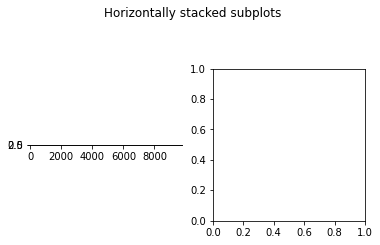

In [156]:
# Visulize dataset
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(img[:, :, 3],cmap=plt.cm.Greys_r)
ax2.imshow(label[0],cmap=plt.cm.Spectral)

In [145]:
# Flattern img
img_f = img.reshape(-1, img.shape[-1])
label = label.flatten()
img_f.shape, label.shape

((97783857, 4), (97783857,))

In [153]:
img_f.shape

(97783857, 4)

In [146]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(img_f, label, test_size=0.2, random_state=1024)
x_train.shape, x_val.shape

((78227085, 4), (19556772, 4))

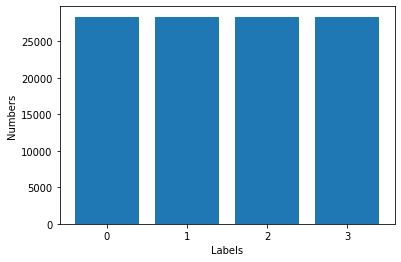

In [147]:
# Balance dataset
rus = RandomUnderSampler(random_state=0)
x_train, y_train = rus.fit_resample(x_train, y_train)
plot_label_distribution(y_train)

# Model

## Suport vector machine

In [66]:
from sklearn.svm import LinearSVC
from sklearn import metrics

In [67]:
svc = LinearSVC()
svc.fit(x_train, y_train)

C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

### Predict

In [68]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
from osgeo import gdal, gdal_array
img_ds_predict = gdal.Open(img_path, gdal.GA_ReadOnly)
img_predict = np.zeros((img_ds_predict.RasterYSize, img_ds_predict.RasterXSize, img_ds_predict.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds_predict.GetRasterBand(1).DataType))

new_shape = (img_predict.shape[0] * img_predict.shape[1], img_predict.shape[2])
img_as_array = img[:, :, :4].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = svc.predict(img_as_array)
# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (1887, 1365, 4) to (2575755, 4)


(1887, 1365, 4)


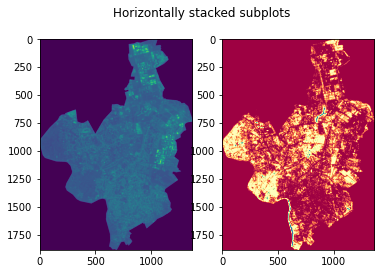

In [69]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
index = [3, 2, 1]
print(img.shape)
img[:, :, index]    
img543 = color_stretch(img, index, (0, 8000))

n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # BG
    (1, (0, 150, 0, 255)),  # Tree
    (2, (0, 0, 255, 255)),  # CoTan
    (3, (0, 123, 255, 255)),  # Water
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(img543[:, :, 2])
ax2.imshow(class_prediction,cmap=plt.cm.Spectral)

In [19]:
class_prediction_svm = np.array([class_prediction]).astype('uint8')
meta.update({'dtype':'uint8'})
out_path_svm = r"E:\WORK\KGX\data\Wv\18FEB03034404-S2AS-013302906040_01_P001_svm.tif"
write_img(class_prediction_svm, meta, out_path_svm)

Exporting file.......
Done


## Random Forest

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (y_train > 0).sum()
print('We have {n} samples'.format(n=n_samples))

We have 85053 samples


In [150]:
# What are our classification labels?
labels = np.unique(y_train[y_train > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

The training data include 3 classes: [1 2 3]


In [151]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees

rf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=30)

# Fit our model to training data
rf = rf.fit(x_train, y_train)

### Predict

In [152]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
from osgeo import gdal, gdal_array
img_ds_predict = gdal.Open(img_path, gdal.GA_ReadOnly)
img_predict = np.zeros((img_ds_predict.RasterYSize, img_ds_predict.RasterXSize, img_ds_predict.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds_predict.GetRasterBand(1).DataType))
new_shape = (img_predict.shape[0] * img_predict.shape[1], img_predict.shape[2])
img_as_array = img[:, :, :4].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))
range_split = list(range(5000000, img_as_array.shape[0], 5000000))
if len(range_split) == 0:
    # Now predict for each pixel
    class_prediction = rf.predict(img_as_array)
else:
    split_img = np.vsplit(img_as_array, range_split)
    class_prediction_ = []
    for img_as_array_ in split_img:
        # Now predict for each pixel
        class_prediction_tmp = rf.predict(img_as_array_)
        class_prediction_.append(class_prediction_tmp)
    class_prediction = np.hstack(class_prediction_)

Reshaped from (9797, 9981, 4) to (97783857, 4)


9797

(9797, 9981, 4)


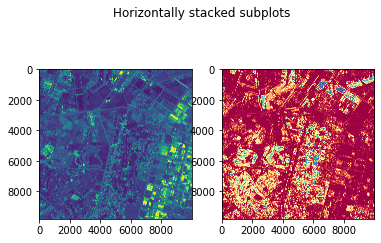

In [129]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
index = [3, 2, 1]
print(img.shape)
img[:, :, index]    
img543 = color_stretch(img, index, (0, 8000))

n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # BG
    (1, (0, 150, 0, 255)),  # Tree
    (2, (0, 0, 255, 255)),  # Water
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(img543[:, :, 2])
ax2.imshow(class_prediction,cmap=plt.cm.Spectral)

In [130]:
# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
class_prediction = np.array([class_prediction]).astype('uint8')

meta.update({'dtype':'uint8'})
out_path = r"E:\WORK\KGX\data\Wv\18FEB03034404-S2AS-013302906040_01_P001_RF.tif"
write_img(class_prediction1, meta, out_path)

Exporting file.......
Done


In [166]:
import cv2
import sys
import glob, os
import numpy as np
import geopandas as gp
import shapefile as shp
import rasterio
from pyproj import Proj, transform
from osgeo import gdal, gdalconst, ogr, osr
import keras
from tensorflow as tf

ModuleNotFoundError: No module named 'shapefile'

In [167]:
def cal_bancut(image_path,num_channel):
    dataset = gdal.Open(image_path)
    band_cut_th = {k: dict(max=0, min=0) for k in range(num_channel)}
    for i_chan in range(num_channel):
        values_ = dataset.GetRasterBand(i_chan+1).ReadAsArray().astype(np.float16)
        values_[values_==0] = np.nan
        band_cut_th[i_chan]['max'] = np.nanpercentile(values_, 98)
        band_cut_th[i_chan]['min'] = np.nanpercentile(values_, 2)
    print(band_cut_th[i_chan]['max'])
    print(band_cut_th[i_chan]['min'])
    return band_cut_th
def convert_dtype(image_path,path_out,num_channel):
    dir_name = os.path.basename(os.path.dirname(image_path))
    image_name = os.path.basename(image_path)[:-4]
    band_cut_th = cal_bancut(image_path,num_channel)
    options_list = ['-ot Byte','-a_nodata 0','-colorinterp_4 undefined']
    for i_chain in range(num_channel):
        options_list.append('-b {}'.format(i_chain+1))
    for i_chain in range(num_channel):
        options_list.append('-scale_{} {} {} 1.0 255.0 -exponent_{} 1.0'.format(i_chain+1,band_cut_th[i_chain]['min'],
                                                                                band_cut_th[i_chain]['max'],i_chain+1))
    output = os.path.join(path_out,image_name+'.tif')
    options_string = " ".join(options_list)
    gdal.Translate(output,
            image_path,
            options=options_string)
    return True

In [168]:
def create_mask_by_shapefile2(shapefile_path, height, width, tr):
    shp = gp.read_file(shapefile_path)
    ls_geo = [(x.geometry) for i, x in shp.iterrows()]
    mask = rasterio.features.rasterize([ls_geo]
                                    ,out_shape=(height, width)
                                    ,transform=tr)
    return mask

def write_img(band, out_meta, out_path):
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(band)

def build_mask(path_image,output_mask,path_shape):
    with rasterio.open(path_image) as src:
        tr = src.transform
        w,h = src.width,src.height
        out_meta = src.meta
    out_meta.update({'count':1})
    mask1 = create_mask_by_shapefile2(path_shape, h, w, tr)*255
    mask1 = np.array([mask1])
    write_img(band, out_meta, output_mask)

In [169]:
def crop_image(fp_img,fp_mask,true_size,overlap_size, path_dir_image_crop,path_dir_mask_crop):
    image_id = os.path.basename(fp_img)
    dataset_image = gdal.Open(fp_img)
    data = dataset_image.ReadAsArray()
    img = np.array(data).swapaxes(0,1).swapaxes(1,2)
    (h,w) = img.shape[0:2]
    dataset_mask = gdal.Open(fp_mask)
    list_hight_1 = list(range(0,h,overlap_size))
    list_weight_1 = list(range(0,w,overlap_size))
    list_hight = []
    list_weight = []
    for i in list_hight_1:
        if i < h - overlap_size:
            list_hight.append(i)        
    list_hight.append(h-overlap_size)
    for i in list_weight_1:
        if i < w - overlap_size:
            list_weight.append(i)        
    list_weight.append(w-overlap_size)
    count = 0
    for i in range(len(list_hight)):
        hight_tiles_up = list_hight[i]
        for j in range(len(list_weight)):
            weight_tiles_up = list_weight[j]
            count = count+1
            output_image = os.path.join(path_dir_image_crop,r'%s_%s.tif'%(image_id,str('{0:03}'.format(count))))
            output_mask = os.path.join(path_dir_mask_crop,r'%s_%s.tif'%(image_id,str('{0:03}'.format(count))))
            gdal.Translate(output_image, dataset_image,srcWin = [weight_tiles_up,hight_tiles_up,true_size,true_size])
            gdal.Translate(output_mask, dataset_mask,srcWin = [weight_tiles_up,hight_tiles_up,true_size,true_size])

In [170]:
from keras import backend as K
from keras.models import Model
from keras.layers import concatenate as merge_l

from keras.optimizers import Adam, Nadam, Adadelta,SGD
from keras.layers import (
    Input, Convolution2D, MaxPooling2D, UpSampling2D,
    Reshape, core, Dropout, Flatten,
    Activation, BatchNormalization, Lambda, Dense, Conv2D, Conv2DTranspose, concatenate,Permute,Cropping2D,Add)
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [171]:
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [172]:
def unet(num_channel,size):
    conv_params = dict(activation='relu', border_mode='same')
    merge_params = dict(axis=-1)
    inputs1 = Input((size, size,int(num_channel)))
    conv1 = Convolution2D(32, (3,3), **conv_params)(inputs1)
    conv1 = Convolution2D(32, (3,3), **conv_params)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3,3), **conv_params)(pool1)
    conv2 = Convolution2D(64, (3,3), **conv_params)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3,3), **conv_params)(pool2)
    conv3 = Convolution2D(128, (3,3), **conv_params)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3,3), **conv_params)(pool3)
    conv4 = Convolution2D(256, (3,3), **conv_params)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3,3), **conv_params)(pool4)
    conv5 = Convolution2D(512, (3,3), **conv_params)(conv5)

    up6 = merge_l([UpSampling2D(size=(2, 2))(conv5), conv4], **merge_params)
    conv6 = Convolution2D(256, (3,3), **conv_params)(up6)
    conv6 = Convolution2D(256, (3,3), **conv_params)(conv6)

    up7 = merge_l([UpSampling2D(size=(2, 2))(conv6), conv3], **merge_params)
    conv7 = Convolution2D(128, (3,3), **conv_params)(up7)
    conv7 = Convolution2D(128, (3,3), **conv_params)(conv7)

    up8 = merge_l([UpSampling2D(size=(2, 2))(conv7), conv2], **merge_params)
    conv8 = Convolution2D(64, (3,3), **conv_params)(up8)
    conv8 = Convolution2D(64, (3,3), **conv_params)(conv8)

    up9 = merge_l([UpSampling2D(size=(2, 2))(conv8), conv1], **merge_params)
    conv9 = Convolution2D(32, (3,3), **conv_params)(up9)
    conv9 = Convolution2D(32, (3,3), **conv_params)(conv9)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)
    optimizer=SGD(lr=1e-4, decay=1e-8, momentum=0.9, nesterov=True)
    model = Model(input=inputs1, output=conv10)
    model.compile(optimizer=optimizer,
                loss=binary_crossentropy,
                metrics=['accuracy', jaccard_coef, jaccard_coef_int])
    return model

In [177]:
unet_model = unet(4, 512)
unet_model.summary()

C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\SkyMap\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 1184        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [211]:
from datetime import datetime
CURRENT_DATE = datetime.now().strftime("Ngay%dThang%mNam%Y_%Hh_%Mp_%Ss")
BATCH_SIZE=2
NUM_CHANNEL=4
NUM_CLASS=1
INPUT_SIZE=512
EARLY=70
SPLIT_RATIO=0.9
MODEL_NAME="KGX_Unet_512_Nuoc"
IMAGE_PATH=r"C:\Users\SkyMap\Desktop\Test\Test\KGX_Unet_512_Nuoc\TrainingDataset\img_crop"
MASK_PATH=r"C:\Users\SkyMap\Desktop\Test\Test\KGX_Unet_512_Nuoc\TrainingDataset\img_mask_crop"
MODEL_DIR=r"C:\Users\SkyMap\Desktop\Test\Test\{}\{}".format(MODEL_NAME, CURRENT_DATE)
MODEL_DIR

'C:\\Users\\SkyMap\\Desktop\\Test\\Test\\KGX_Unet_512_Nuoc\\Ngay07Thang09Nam2021_13h_00p_00s'

In [202]:
from datetime import datetime
a = datetime.now().strftime("Ngay%dThang%mNam%Y_%H_%M_%S")
a

'Ngay07Thang09Nam2021_11_57_27'

In [214]:
        --num-channel=${NUM_CHANNEL} \
        --num-class=${NUM_CLASS}\
        --input_size=${INPUT_SIZE}\
        --split_ratio=${SPLIT_RATIO}\
        --image_path=${IMAGE_PATH}\
        --mask_path=${MASK_PATH}\
        --num-epochs=500\
        --job-dir=${MODEL_DIR}\
        --prefix=${CURRENT_DATE}\
        --batch-size=${BATCH_SIZE}\
        --early-stop=${EARLY}\
        --thres_neg=1\
        --scale_neg=20

NameError: name 'create_list_id' is not defined